In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

import tensorflow as tf

pd.options.display.max_columns = None

In [2]:
df_covid = pd.read_csv('./Covid_clean.csv')
df_covid.head()

C:\Users\ismael\AppData\Local\Temp\ipykernel_28656\3897149584.py:1: DtypeWarning: Columns (4,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid = pd.read_csv('./Covid_clean.csv')


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,fallecidos,mes,mes_nombre
0,2,1,1,1,2020-05-03,1.0,65.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1,5,May
1,2,1,0,1,2020-06-03,1.0,72.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5,1,6,June
2,2,1,0,0,2020-06-09,0.0,55.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,6,June
3,2,1,1,1,2020-06-12,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1,6,June
4,2,1,0,1,2020-06-21,0.0,68.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1,6,June


In [18]:
df_covid.shape

(1024829, 21)

In [3]:
# creamos el modelo de clasificacion

features = ['USMER', 'SEX', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'PATIENT_TYPE']
target = 'fallecidos'




In [4]:
df_covid['fallecidos'].unique()

array([1, 0], dtype=int64)

# Rebalanceo y xGboost


In [5]:
X = df_covid[features]
y = df_covid[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
model.fit(X_train, y_train)

# Definición de los hiperparámetros a ajustar
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}

# Instancia de Grid Search Cross Validation
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)

# Entrenamiento del modelo con Grid Search
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evaluación del modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Mejores hiperparámetros: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.8837465726022853


              precision    recall  f1-score   support

           0       0.99      0.88      0.93    190238
           1       0.38      0.93      0.54     14728

    accuracy                           0.88    204966
   macro avg       0.68      0.91      0.73    204966
weighted avg       0.95      0.88      0.90    204966

Accuracy: 0.8837465726022853
Precision: 0.37544483985765126
Recall: 0.9312194459532862
F1: 0.5351359787740451
Matriz de confusión: [[167423  22815]
 [  1013  13715]]


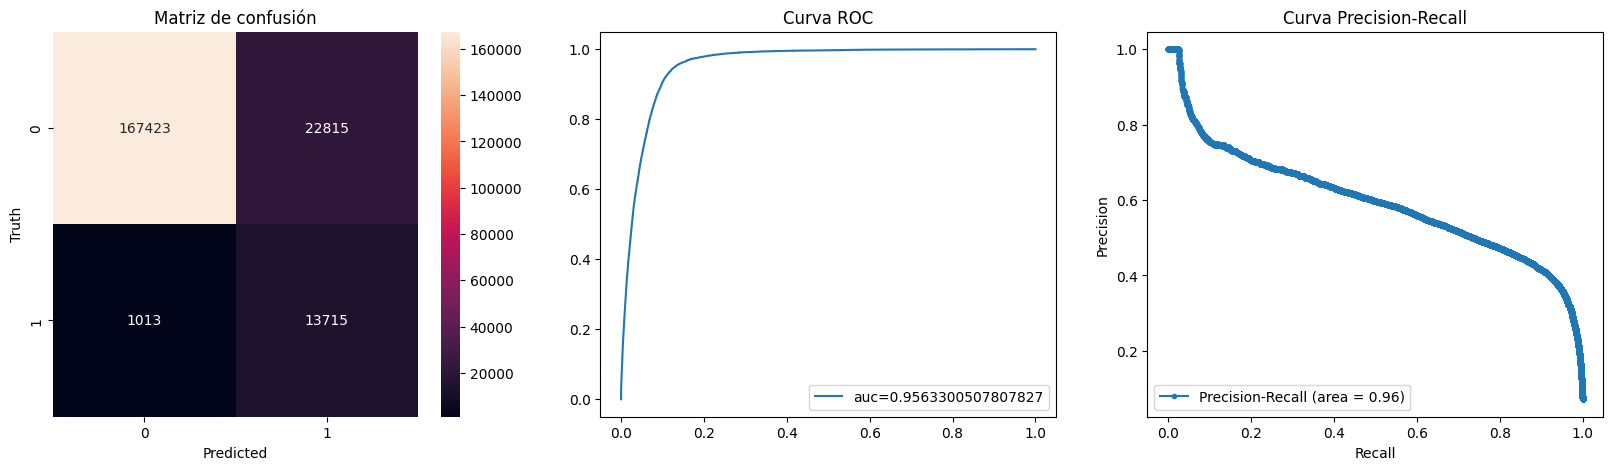

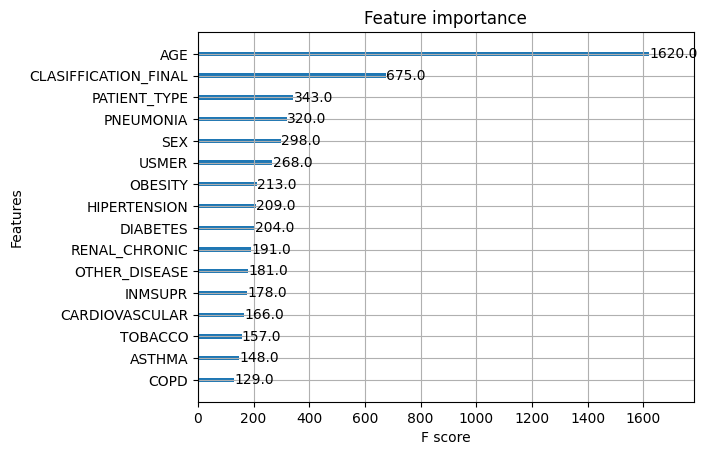

In [15]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1:", f1)


# grafiocamos la matriz de confusión

cm = confusion_matrix(y_test, y_pred)

print(f'Matriz de confusión: {cm}')
# Curva ROC

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Curva Precision-Recall

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# ploteo los 3 graficos en un mosaico

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Truth')
ax[0].set_title('Matriz de confusión')

ax[1].plot(fpr,tpr,label="auc="+str(auc))
ax[1].legend(loc=4)
ax[1].set_title('Curva ROC')

ax[2].plot(recall, precision, marker='.', label='Precision-Recall (area = %0.2f)' % auc)
ax[2].legend(loc="lower left")
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Curva Precision-Recall')

xgb.plot_importance(model)

plt.show()


plt.show()

# Analisis de falsos negativos

In [9]:
# buscamos los falsos negativos y armamos un df con ellos

falsos_negativos = np.where((y_test == 1) & (y_pred == 0))[0]

# Busco los indices de los falsos negativos
indices = X_test.iloc[falsos_negativos].index

# Armo un df con los falsos negativos

df_falsos_negativos = df_covid.loc[indices]

df_falsos_negativos['falsos_negativos'] = y_pred[falsos_negativos]

features = ['USMER', 'SEX', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'PATIENT_TYPE', 'fallecidos', 'falsos_negativos']

df_falsos_negativos[features].head(10)


,USMER,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,PATIENT_TYPE,fallecidos,falsos_negativos
36804,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1,0
48941,1,1,0.0,50.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,1,1,0
334520,2,0,0.0,25.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,3,0,1,0
49932,2,0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,1,1,0
448225,2,0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,1,0
52971,1,1,0.0,77.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1,1,0
53340,1,0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,1,0
44461,1,0,0.0,64.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1,1,0
451354,2,1,0.0,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,1,1,0
441326,2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,1,0


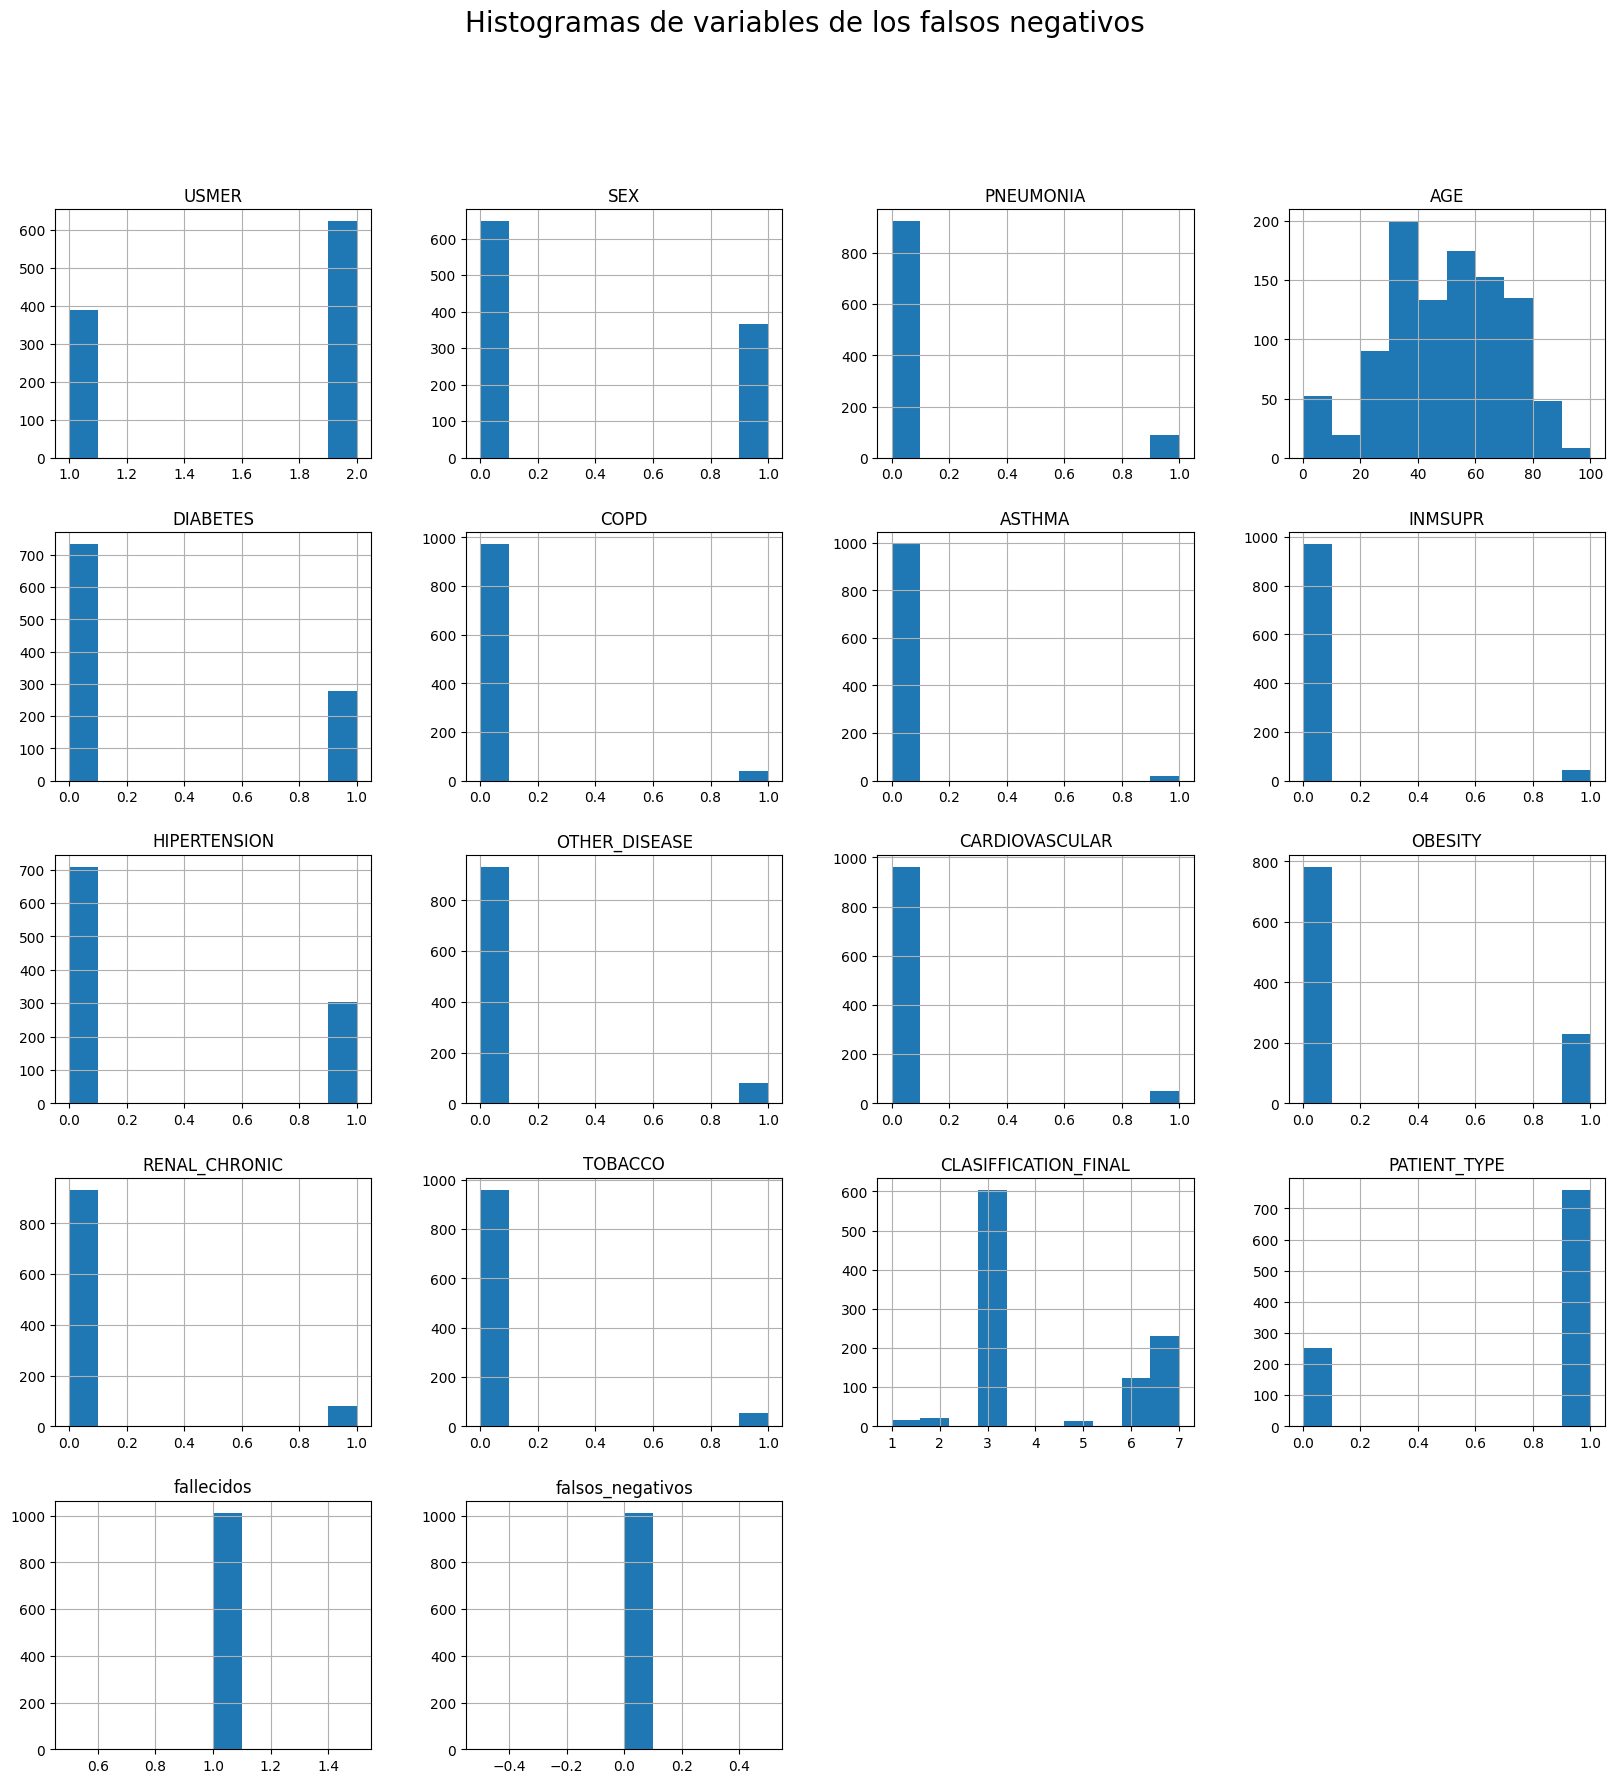

In [10]:

# graficamos las variables de df_falsos_negativos

df_falsos_negativos[features].hist(figsize=(20,20))
# agrego titulo

plt.suptitle('Histogramas de variables de los falsos negativos', fontsize=20)
plt.savefig('histogramas_falsos_negativos.png')
plt.show()


In [11]:
# buscamos los falsos positivos y armamos un df con ellos

falsos_positivos = np.where((y_test == 0) & (y_pred == 1))[0]

# Busco los indices de los falsos negativos
indices = X_test.iloc[falsos_positivos].index

# Armo un df con los falsos negativos

df_falsos_positivos = df_covid.loc[indices]

df_falsos_positivos['falsos_negativos'] = y_pred[falsos_positivos]

features = ['USMER', 'SEX', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'PATIENT_TYPE', 'fallecidos', 'falsos_negativos']

df_falsos_positivos[features].head(10)


,USMER,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,PATIENT_TYPE,fallecidos,falsos_negativos
271938,2,1,1.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,1,0,1
10968,1,1,1.0,49.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7,0,0,1
217922,1,1,1.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0,0,1
375447,1,0,1.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,1,0,1
608948,1,1,0.0,65.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1
4416,2,0,1.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1
239681,2,1,1.0,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,0,0,1
328379,1,0,1.0,78.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1
846235,1,1,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0,0,1
344222,2,0,0.0,45.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,0,0,1


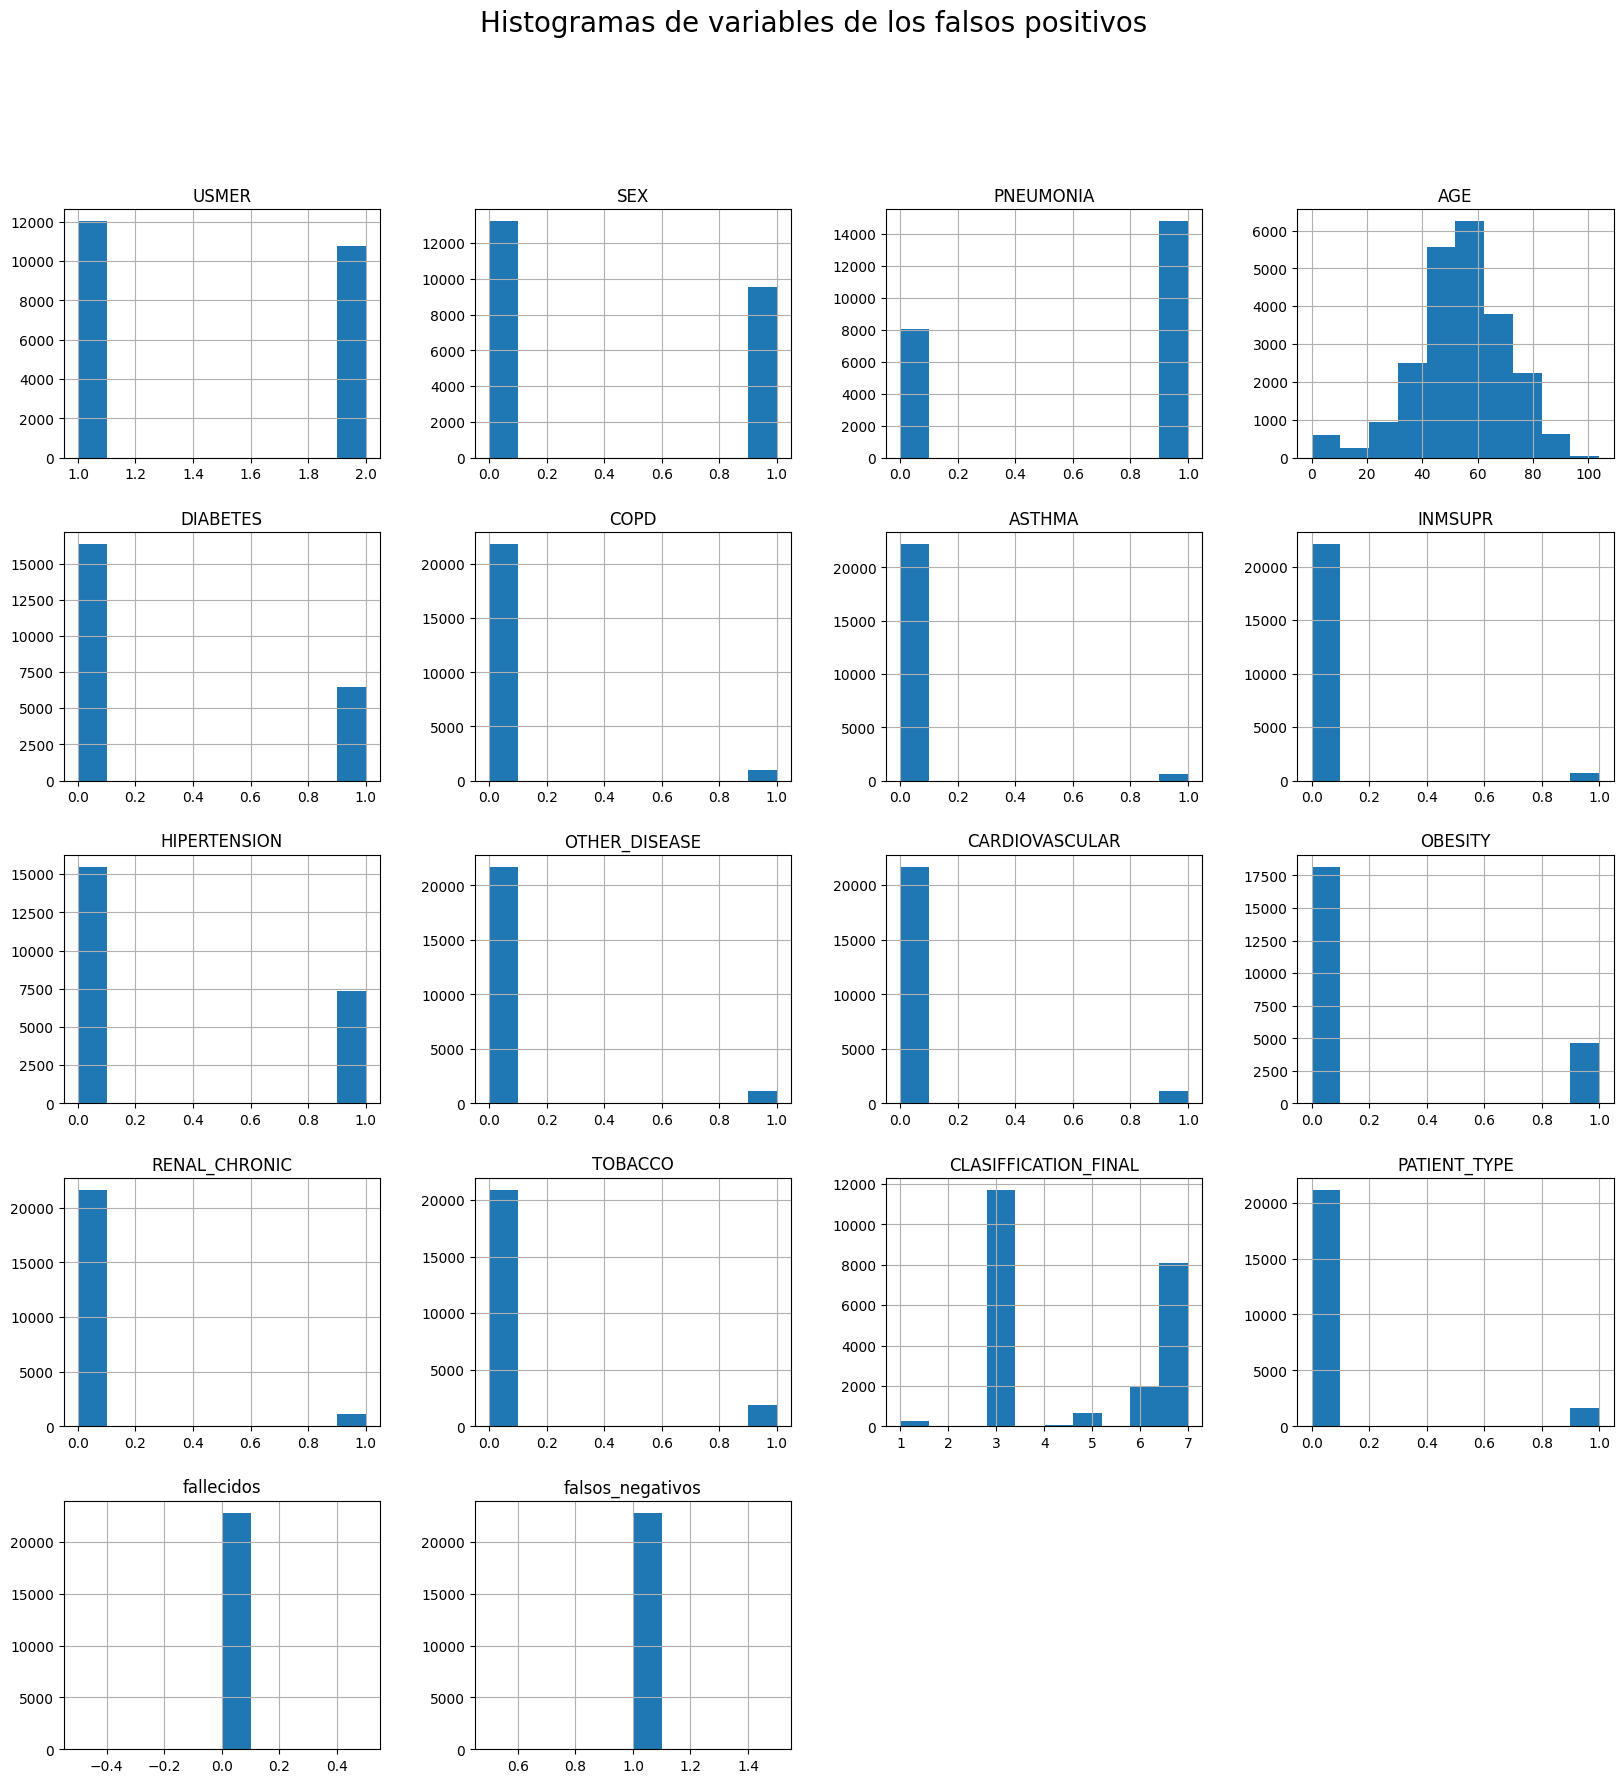

In [12]:
df_falsos_positivos[features].hist(figsize=(20,20))
# agrego titulo

plt.suptitle('Histogramas de variables de los falsos positivos', fontsize=20)
plt.savefig('histogramas_falsos_positivos.png')
plt.show()